# IREN - Navires 2021 à partir d'un réseau existant

## Authors

Group: **CheckThisOutGoogle**

- Theo Lepage (theo.lepage)
- Nicolas Blin (nicolas.blin)

## Table of content

1. [Load and prepare data (_train_, _val_ and _test_ sets)](#section-one)
    - 1.1 [Analyse data and visualize images](#section-dataset-1)
    - 1.2 [Create _test_ set manually](#section-dataset-2)
    - 1.3 [Create data generators for _train_ and _val_ sets](#section-dataset-3)
2. [Create the model](#section-two)
3. [Train the model](#section-three)
    - 3.1 [First step: train only the _top_ layers](#section-three-1)
    - 3.2 [Second step: fine-tune the model](#section-three-2)
4. [Evaluate the model](#section-four)
    - 4.1 [Scores](#section-four-1)
    - 4.2 [Confusion matrix](#section-four-2)
    - 4.3 [Results analysis](#section-four-3)
    - 4.4 [Test with our own images](#section-four-4)
    - 4.5 [Conclusion](#section-four-5)
5. [Submit results for competition](#section-five)

In [1]:
TRAIN_PATH = '/kaggle/working/train/'

TEST_PATH = '/kaggle/working/test/'
NB_TEST_IMAGES_PER_CLASS = 100

CATEGORIES = ['coastguard',        # bateau garde-côtes
              'containership',     # bateau porte-conteneurs
              'corvette',          # petit navire de guerre
              'cruiser',           # bateau de croisière
              'cv',                # porte-avions
              'destroyer',         # navire de guerre avec missiles
              'ferry',             # ferry
              'methanier',         # navire transportant du gaz
              'sailing',           # bateau à voiles
              'smallfish',         # bateau de peche
              'submarine',         # sous-marin
              'tug',               # remorqueur
              'vsmallfish']        # bateau de peche (orientation paysage)

NB_CLASSES = len(CATEGORIES)

IMG_DIM = (128, 192)
NETWORK_IMG_DIM = (224, 224)
BATCH_SIZE = 64
VAL_SPLIT = 0.1

In [2]:
!nvidia-smi

Wed Apr 21 14:09:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id="section-one"></a>

# Load and prepare data (_train_, _val_ and _test_ sets)

We are going to create three separate sets:
- A _test_ set (`NB_TEST_IMAGES_PER_CLASS` images per category from the original train set)
- A _train_ set (90% of the remaining samples, with data augmentation)
- A _validation_ set (10% of the remaining samples, with data augmentation)


We do not normalize values between `0.0` and `1.0` as the network we are using takes values in range $[0; 255]$.

In [3]:
# Extract dataset
!tar xzf /kaggle/input/ships2021/ships2021.tgz
!ls /kaggle/working/train/

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


## Analyse data and visualize images

<a id="section-dataset-1"></a>

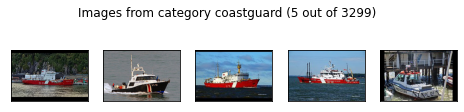

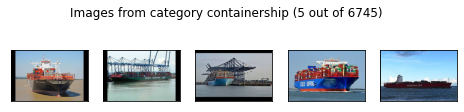

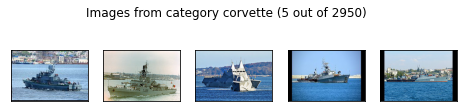

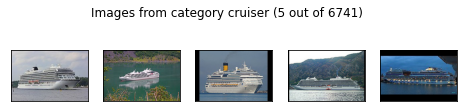

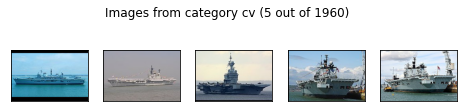

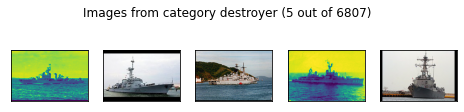

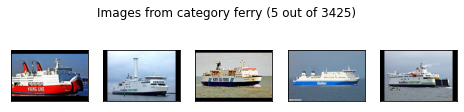

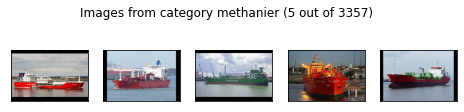

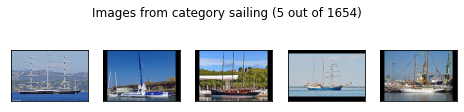

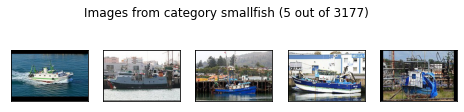

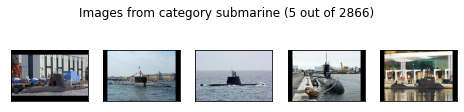

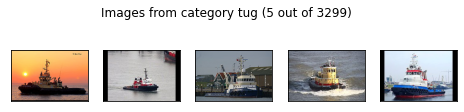

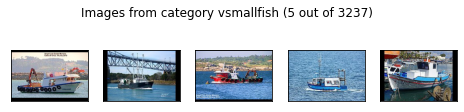

In [4]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

nb_images_per_class_to_show = 5

def get_images_of_class(category):
    images = []
    images_path = glob.glob(TRAIN_PATH + category + '/*.jpg')
    for path in images_path[0:nb_images_per_class_to_show]:
        images.append(Image.open(path))
    return images, len(images_path)

# Show images for each category
for category in CATEGORIES:
    plt.figure(figsize=[8, 2])
    
    images, count = get_images_of_class(category)

    fig = plt.gcf()
    fig.suptitle("Images from category {} ({} out of {})".format(category,
                                                                 nb_images_per_class_to_show,
                                                                 count))
    
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
    plt.show()

**Observations**:
- Images are taken from land or sea and are centered around the ship.
- The dataset is not balanced (i.e. we do not have the same number of images for each category).
- As opposed to the dataset of competition 1, images ratio is preserved (all images are $128 \times 192$) and thus black lines may appear on the sides.

## Create _test_ set manually

<a id="section-dataset-2"></a>

Creating a test set is a good practice as it allows us to check that we have not specialized the hyperparameters for the validation set.  
Thus, we extract `NB_TEST_IMAGES_PER_CLASS` (100 by default) per category from the `train` directory and load everything into memory to later evaluate the model performances.

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from pathlib import Path

def load_test_set():
    # Create test dir
    Path(TEST_PATH).mkdir(exist_ok=True)

    X_test = np.empty((NB_CLASSES * NB_TEST_IMAGES_PER_CLASS, IMG_DIM[0], IMG_DIM[1], 3))
    Y_test = np.empty((NB_CLASSES * NB_TEST_IMAGES_PER_CLASS, NB_CLASSES))

    sample_index = 0
    for category_index, category in enumerate(CATEGORIES):
        # Get filenames of NB_TEST_IMAGES_PER_CLASS for each category
        images_path = glob.glob(TRAIN_PATH + category + '/*.jpg')
        images_path = images_path[0:NB_TEST_IMAGES_PER_CLASS]

        Path(TEST_PATH + category).mkdir()

        for path in images_path:
            # Load and, normalize and resize image
            img = Image.open(path)
            img = np.array(img)

            #  Convert grayscale images to RGB
            if len(img.shape) == 2:
                img = np.stack([img] * 3, axis=-1)

            # Store image and label value
            X_test[sample_index] = img
            Y_test[sample_index] = to_categorical(category_index, num_classes=NB_CLASSES)
            sample_index += 1

            # Move image outside of training set directory
            dst_path = Path(path.replace('train', 'test'))
            Path(path).replace(dst_path)

    # Shuffle X_test and Y_test
    X_test, Y_test = shuffle(X_test, Y_test)
    return X_test, Y_test

X_test, Y_test = load_test_set()

(1300, 128, 192, 3) (1300, 13)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


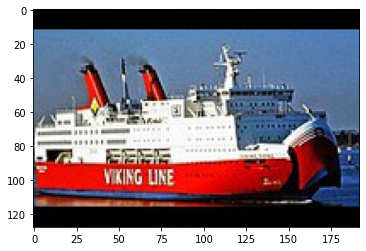

In [6]:
print(X_test.shape, Y_test.shape)

plt.imshow(X_test[8] / 255.0)
print(Y_test[8])

## Create data generators for _train_ and _val_ sets

<a id="section-dataset-3"></a>

The following **data augmentation** transformations are randomly applied "online" (during training, when retrieving a batch):
- Horizontal flip
- Zoom ($20\%$ of width/height)
- Rotation (+/- $30$ degrees)
- Horizontal shift ($20\%$ of width)
- Vertical shift ($20\%$ of height)
- Shearing

The objective is to reduce **overfitting** by adding more training samples which could help the model to generalize.

**Notes**:
- Compared to the notebook for competition 1, all transformations factors have been increased to add even more variability among training samples.
- Specifically, we randomly rotate images of +/- $30$ degrees to be sure to handle images rotated from +/- $20$ degrees which is the objective of this competition. 

In [7]:
from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   validation_split=VAL_SPLIT)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=IMG_DIM,
                                                    batch_size=BATCH_SIZE,
                                                    subset="training")

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                         target_size=IMG_DIM,
                                                         batch_size=BATCH_SIZE,
                                                         subset="validation")

Found 43402 images belonging to 13 classes.
Found 4815 images belonging to 13 classes.


<a id="section-two"></a>

# Create the model

We chose **EfficientNet** [1] which is relatively recent but serves as the base for several state-of-the-art techniques. Indeed, according to ImageNet benchmarks [2], EfficientNet surpasses models based on previous methods such as VGG, ResNet or Inception.

The original article introduces several variations from B0 to B7 with different input shapes to fit different classification tasks.
In our case, we used **EfficientNet B0** [3] designed for an input image resolution of $224 \times 224$ which is close to the images from the ships dataset. The advantage is that B0 is the lightest model with only 5 millions parameters.

---

**References**:

- [1] Mingxing Tan and Quoc V. Le. [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf). ICML 2019.
- [2] https://paperswithcode.com/sota/image-classification-on-imagenet
- [3] https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0

In [8]:
from tensorflow.keras import Model

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import EfficientNetB0

In the following cell, we create our model with Keras functional API by loading a pre-trained EfficientNet B0 without its _top layers_ (the last layers reponsible of the predictions). By default we disable the training of its parameters with `efficient_net_b0.trainable = False`. Finally, we add custom _top layers_ to match the number of categories of the ships dataset.

**GlobalAveragePooling2D** layer is used before the final dense layer to average the spatial features of EfficientNet (`(batch_size, rows, cols, channels)` -> `(batch_size, channels)`). This way we extract from EfficientNet a feature vector of $1280$ values.

In [16]:
from tensorflow.image import resize

def create_model():
    # Retrieve pre-trained EfficientNet B0 without its top layers
    efficient_net_b0 = EfficientNetB0(include_top=False, weights="imagenet")

    print('EfficientNet B0 is composed of {} layers.'.format(len(efficient_net_b0.layers)))

    # Freeze the pretrained weights
    efficient_net_b0.trainable = False

    inputs = Input((IMG_DIM[0], IMG_DIM[1], 3))
    X = resize(inputs, [NETWORK_IMG_DIM[0], NETWORK_IMG_DIM[1]], method='nearest')

    X = efficient_net_b0(X)
    
    # Add our custom top layers
    X = GlobalAveragePooling2D()(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.5)(X)
    
    outputs = Dense(NB_CLASSES, activation="softmax")(X)
    model = Model(inputs, outputs)
    return model

In [17]:
model = create_model()

model.summary()

EfficientNet B0 is composed of 237 layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 192, 3)]     0         
_________________________________________________________________
tf.image.resize_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense) 

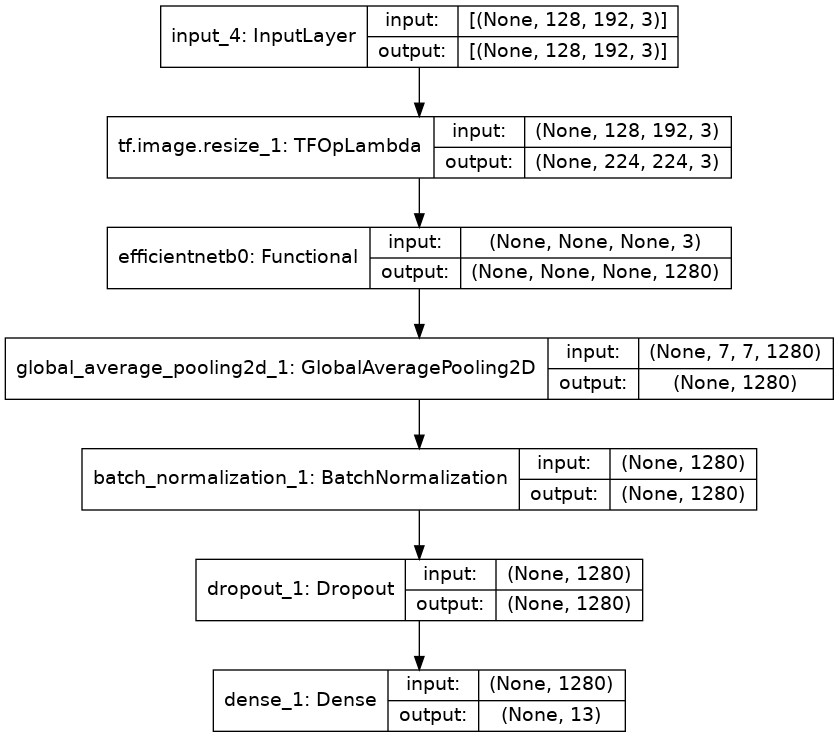

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

<a id="section-three"></a>

# Train the model

In order to apply a pre-trained EfficientNet B0 model to a different image classification task we are going to rely on **transfer learning**.

1. During a first step we are going to freeze the weights of all layers to only train the _top_ layers (the last layers reponsible of the predictions).
2. Then, we are going to fine-tune the model (our _top_ layers and some EfficientNet B0 layers) with a smaller learning rate.

This last step is necessary as EfficientNet B0 (the feature extractor) was trained on a relatively different dataset from ours (ImageNet).

---

**References**:

- https://keras.io/guides/transfer_learning/
- https://keras.io/api/applications/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

<a id="section-three-1"></a>

## First step: train only the _top_ layers

The training of the top layers is done with `Adam` optimizer. Initially, the layers we added after EfficientNet are initialized randomly. Therefore, we used a high learning rate ($1 . 10^{-2}$) to accelerate training time.

Our top layers are directly trained on the feature vector of $1280$ values provided by EfficientNet, which simplify the classification task and should make the training faster.

In [19]:
model.compile(optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./checkpoints/iren-2.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5)

In [21]:
history_1 = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs=30,
                      callbacks=[early_stopping, save_callback])

Epoch 1/30
679/679 [==============================] - 302s 437ms/step - loss: 1.9571 - accuracy: 0.5787 - val_loss: 0.8421 - val_accuracy: 0.7148

Epoch 00001: val_loss improved from inf to 0.84213, saving model to ./checkpoints/iren-2.ckpt
Epoch 2/30
679/679 [==============================] - 291s 428ms/step - loss: 1.0146 - accuracy: 0.6641 - val_loss: 0.7931 - val_accuracy: 0.7165

Epoch 00002: val_loss improved from 0.84213 to 0.79306, saving model to ./checkpoints/iren-2.ckpt
Epoch 3/30
679/679 [==============================] - 289s 425ms/step - loss: 0.9664 - accuracy: 0.6733 - val_loss: 0.8279 - val_accuracy: 0.7099

Epoch 00003: val_loss did not improve from 0.79306
Epoch 4/30
679/679 [==============================] - 289s 426ms/step - loss: 0.9835 - accuracy: 0.6682 - val_loss: 0.7972 - val_accuracy: 0.7119

Epoch 00004: val_loss did not improve from 0.79306
Epoch 5/30
679/679 [==============================] - 288s 424ms/step - loss: 1.0018 - accuracy: 0.6643 - val_loss: 0.

In [23]:
model.load_weights(checkpoint_path)

In [24]:
model.evaluate(X_test, Y_test)

41/41 [==============================] - 2s 40ms/step - loss: 0.6586 - accuracy: 0.7738


[0.6586394309997559, 0.7738461494445801]

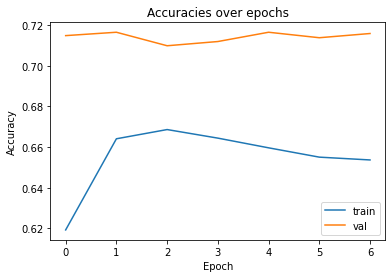

In [27]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

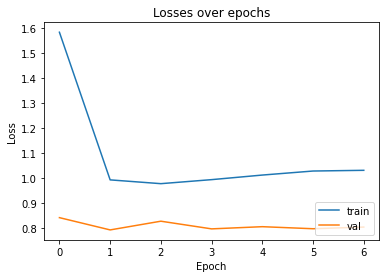

In [28]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

**Observations**:

- The training was quite fast: 30 minutes on a Tesla P100 GPU.
- We used early stopping to retrieve the best model before overfitting.
- The validation accuracy is often better than the train accuracy as the regularization is strong and thus affect training metrics.
- The best validation accuracy is not good enough compared to the model we trained for the first competition achieving $94\%$.
- Fine-tuning some pre-trained and our top layers could help reaching better results.

<a id="section-three-2"></a>

## Second step: fine-tune the model

We decided to fine-tune only the last 25 layers of EfficientNet ($\approx 10\%$ of its layers) to accelerate training time and because we make the assumption that the first layers are already capturing high-level generalist patterns in input images.  

The learning rate is smaller ($5 . 10^{-4}$) to prevent modifying too much the pre-trained weights.  

In [25]:
nb_layers_to_finetune = 25

# EfficientNet weights are already frozen (see create_model())
for layer in model.layers[-nb_layers_to_finetune:]:
    # Avoid fine-tuning BatchNormalization layers
    # See "Important notes about BatchNormalization layer"
    # https://keras.io/guides/transfer_learning/
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

In [26]:
history_2 = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs=20, 
                      callbacks=[early_stopping, save_callback])

Epoch 1/20
679/679 [==============================] - 407s 587ms/step - loss: 0.7329 - accuracy: 0.7459 - val_loss: 0.3595 - val_accuracy: 0.8648

Epoch 00001: val_loss improved from 0.79306 to 0.35950, saving model to ./checkpoints/iren-2.ckpt
Epoch 2/20
679/679 [==============================] - 394s 580ms/step - loss: 0.3360 - accuracy: 0.8753 - val_loss: 0.3434 - val_accuracy: 0.8771

Epoch 00002: val_loss improved from 0.35950 to 0.34337, saving model to ./checkpoints/iren-2.ckpt
Epoch 3/20
679/679 [==============================] - 392s 577ms/step - loss: 0.2635 - accuracy: 0.9006 - val_loss: 0.3354 - val_accuracy: 0.8795

Epoch 00003: val_loss improved from 0.34337 to 0.33541, saving model to ./checkpoints/iren-2.ckpt
Epoch 4/20
679/679 [==============================] - 390s 574ms/step - loss: 0.2263 - accuracy: 0.9131 - val_loss: 0.2735 - val_accuracy: 0.9043

Epoch 00004: val_loss improved from 0.33541 to 0.27346, saving model to ./checkpoints/iren-2.ckpt
Epoch 5/20
679/679 [

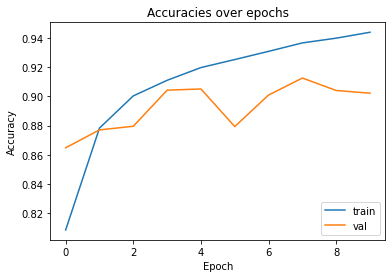

In [29]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

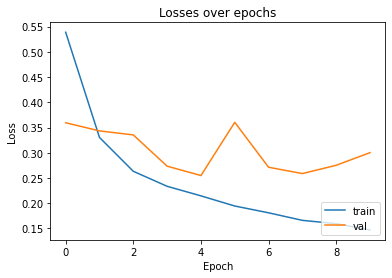

In [31]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

**Observations**:
- The fine-tuning step took approximately 1 hour on a Tesla P100 GPU.
- Fine-tuning the model helped reaching a better validation accuracy: from $70\%$ to $\approx 90\%$.
- Unfortunately, the model is overfitting quickly after epoch 5.

In [33]:
model.load_weights(checkpoint_path)

<a id="section-four"></a>

# Evaluate the model

<a id="section-four-1"></a>

## Scores

In [34]:
model.evaluate(X_test, Y_test)

41/41 [==============================] - 2s 38ms/step - loss: 0.2390 - accuracy: 0.9108


[0.23897932469844818, 0.9107692241668701]

In [35]:
from sklearn.metrics import classification_report

Y_test_pred = model.predict(X_test).argmax(axis=-1)

report = classification_report(Y_test.argmax(axis=-1),
                               Y_test_pred,
                               target_names=CATEGORIES,
                               zero_division=0)

print(report)

               precision    recall  f1-score   support

   coastguard       0.95      0.87      0.91       100
containership       0.96      0.99      0.98       100
     corvette       0.91      0.91      0.91       100
      cruiser       0.93      1.00      0.97       100
           cv       0.99      0.89      0.94       100
    destroyer       0.82      0.98      0.89       100
        ferry       0.99      0.91      0.95       100
    methanier       0.99      0.99      0.99       100
      sailing       0.99      0.95      0.97       100
    smallfish       0.65      0.91      0.76       100
    submarine       0.98      0.97      0.97       100
          tug       0.93      0.99      0.96       100
   vsmallfish       0.89      0.48      0.62       100

     accuracy                           0.91      1300
    macro avg       0.92      0.91      0.91      1300
 weighted avg       0.92      0.91      0.91      1300



**Observations**:
- The final accuracy on the test set is $91.08\%$ which is less than what we obtained with a shallow network for competition 1 ($92.77\%$).
- Similarly, averaged precision, recall and F1-score are slightly lower.

<a id="section-four-2"></a>

## Confusion matrix

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

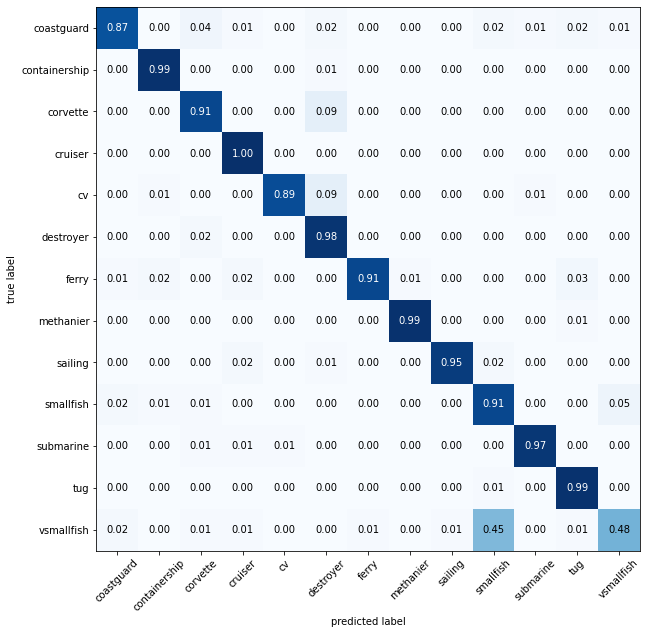

In [36]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(Y_test.argmax(axis=-1), Y_test_pred)

plot_confusion_matrix(cm,
                      class_names=CATEGORIES,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10))

**Observations**:
- As opposed to our shallow CNN of competition 1, most errors are made on classes `smallfish` and `vsmallfish` which are very similar categories. We can make the assumption that features vectors provided by EfficientNet are too close which prevents the final dense layer to distinguish between images from these two categories. The fine-tuning step could have been done on more layers to solve this.
- Similarly to the previous model, images from categories `coastguard`, `cv` and `corvette` are causing many predictions errors.

<a id="section-four-3"></a>

## Results analysis

In [37]:
def plot_errors(X, Y, Y_pred, nb_images=30):
    plt.figure(figsize=(10, 15))
    
    pos_in_figure = 0
    for i in range(len(X)):
        if pos_in_figure >= nb_images:
            break

        if Y[i] == Y_pred[i]: # Skip correct predictions
            continue

        label_pred = CATEGORIES[Y_pred[i]]
        label_actual = CATEGORIES[Y[i]]
            
        plt.subplot(10, 5, pos_in_figure + 1)
        plt.imshow(X[i] / 255)            
        plt.title("Actual={}\n Pred={}".format(label_actual, label_pred))
        plt.axis("off")
        
        pos_in_figure += 1
    
    plt.tight_layout()
    plt.show()

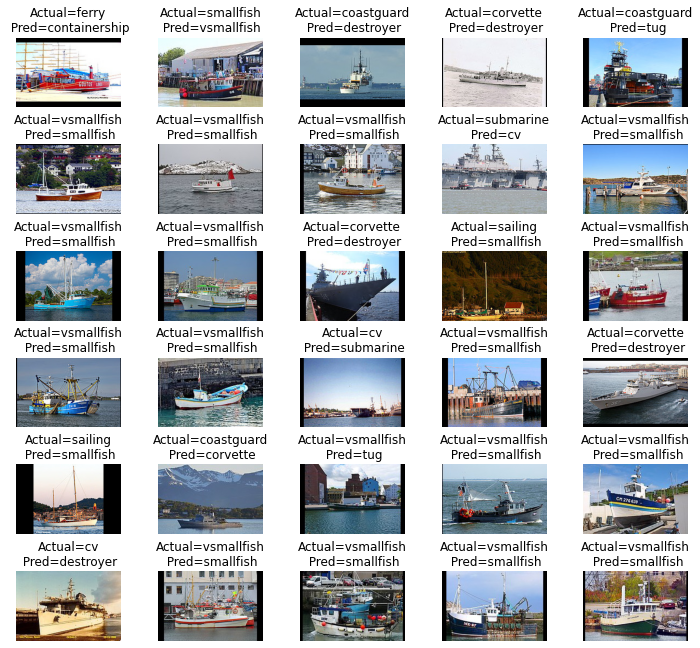

In [38]:
# Show errors made by the model
plot_errors(X_test, Y_test.argmax(axis=-1), Y_test_pred)

**Observations**:
- The errors shown on the figure above confirm the previous observations related to the similarity between classes `smallfish` and `vsmallfish`.
- One solution could be to use a separate classifier and use only this CNN model to discriminate between very different classes. Adjusting the threshold of this classifier could help to balance the number of false negatives and false positives to improve the recall and precision for these two categories.

<a id="section-four-4"></a>

## Test on our own images

In [39]:
def load_test_20_ships_set():
    X_test_20 = np.empty((20, IMG_DIM[0], IMG_DIM[1], 3))
    Y_test_20 = np.empty((20, NB_CLASSES))

    sample_index = 0
    for category_index, category in enumerate(CATEGORIES):
        images_path = glob.glob('/kaggle/input/our20ships/our-20-ships/' + category + '/*.jpg')

        for path in images_path:
            # Load and, normalize and resize image
            img = Image.open(path)
            img = img.resize((IMG_DIM[1], IMG_DIM[0]), Image.NEAREST)
            img = np.array(img)

            # Store image and label value
            X_test_20[sample_index] = img
            Y_test_20[sample_index] = to_categorical(category_index, num_classes=NB_CLASSES)
            sample_index += 1
            
    return X_test_20, Y_test_20

# Test on our 20 ships images
X_test_20, Y_test_20 = load_test_20_ships_set()
print(X_test_20.shape, Y_test_20.shape)

(20, 128, 192, 3) (20, 13)


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


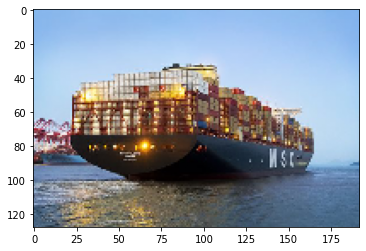

In [40]:
test_i = 2
plt.imshow(X_test_20[test_i] / 255)
print(Y_test_20[test_i])

In [41]:
model.evaluate(X_test_20, Y_test_20)

1/1 [==============================] - 0s 44ms/step - loss: 0.2214 - accuracy: 0.9000


[0.22138860821723938, 0.8999999761581421]

**Observations**:
- Surprisingly this new model is better at classifying our custom test set composed of images retrieved from the internet.
- It seems to understand better very different categories of ships but make more errors on similar categories which is understandable as it was pre-trained on a very different dataset (ImageNet).

<a id="section-four-5"></a>

## Conclusion

The results are surprising as we obtained a slightly lower accuracy with a deeper CNN which was pre-trained to classify images from 1000 categories. Howeverm few of them are related to boats (fireboat, lifeboat, speedboat, boathouse and submarine). This could explain why this model work better when classifying ships that do not look alike but struggle with classes `smallfish` and `vsmallfish` as opposed to our model specifically trained from scratch for this task.

Training such a model, even if the number of trainable parameters is equivalent, was harder and preventing overfitting became a challenge. However, transfer learning is a promising technique for many tasks as it was helpful to reduce training time by dividing it by two.

<a id="section-five"></a>

# Submit results for competition

In [42]:
import pandas as pd

# Load submission test set
X_test_final = np.load('/kaggle/working/test_rot.npy', allow_pickle=True)
X_test_final = X_test_final.astype('float32')
print(X_test_final.shape)

# Determine predictions
res = model.predict(X_test_final).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

(2315, 128, 192, 3)


In [43]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv